# import các thư viện cần thiết


In [ ]:
import os
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import cv2
import shutil
from shutil import copyfile
import path

In [ ]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

# Tìm hiểu dữ liệu

In [ ]:
import os
data_folder = "/kaggle/input/brain-tumor-object-detection-datasets"
output_folder = 'braintumors'
data_folder_yolo = output_folder + "_yolo"
data_folder_coco = output_folder + "_coco"
folders = os.listdir(data_folder)
print(folders)

['coronal_t1wce_2_class', 'axial_t1wce_2_class', 'sagittal_t1wce_2_class']


In [ ]:
from glob import glob
def count_yolo_data(folder):
    for images_labels in ['images', 'labels']:
        for train_test in ['train', 'test']:
            file_ext = '*.jpg' if images_labels == 'images' else '*.txt'
            p = os.path.join(folder, images_labels, train_test, file_ext)
            files = glob(p)
            print(train_test, images_labels, len(files))

In [ ]:
for folder in folders:
    print('-'*8 + folder + '-'*8)
    folder = os.path.join(data_folder, folder)
    count_yolo_data(folder)

--------coronal_t1wce_2_class--------
train images 319
test images 78
train labels 318
test labels 78
--------axial_t1wce_2_class--------
train images 310
test images 75
train labels 296
test labels 75
--------sagittal_t1wce_2_class--------
train images 264
test images 70
train labels 264
test labels 70


# Xử lý dữ liệu

In [ ]:
import os
import shutil
from tqdm import tqdm
# move all into one folder
def copy_yolo_files(from_folder, to_folder, images_labels, train_test):
    from_path = os.path.join(from_folder, images_labels, train_test)
    to_path = os.path.join(to_folder, images_labels, train_test)
    os.makedirs(to_path, exist_ok = True)
    # get files
    file_ext = "*.jpg" if images_labels == "images" else "*.txt"
    files = glob(os.path.join(from_path, file_ext))
    # move files
    for file in tqdm(files):
        shutil.copy(file, to_path)

In [ ]:
# copy
for from_folder in folders:
    from_folder = os.path.join(data_folder, from_folder)
    to_folder = data_folder_yolo
    for images_labels in ['images', 'labels']:
        for train_test in ['train', 'test']:
            copy_yolo_files(from_folder, to_folder, images_labels, train_test)


100%|██████████| 70/70 [00:00<00:00, 926.90it/s]


In [ ]:
!tree -d {data_folder_yolo}

braintumors_yolo
|-- images
|   |-- test
|   `-- train
`-- labels
    |-- test
    `-- train

6 directories


In [ ]:
# read the yaml file and write the class file
import yaml
from yaml.loader import SafeLoader

# Open the file and load the file
with open(os.path.join(data_folder, folders[0], folders[0]+'.yaml')) as f:
      classes = yaml.load(f, Loader=SafeLoader)["names"]
# Write classes.txt
with open(os.path.join(data_folder_yolo, "classes.txt"), "w") as f:
      f.write('\n'.join(classes))

In [ ]:
!pip install -q pylabel

In [ ]:
#chuyển dữ liệu dạng yolo sang dạng COCO
from pylabel import importer
def yolo_to_coco(input_folder, output_folder, train_test):
    labels_path = os.path.join(input_folder, "labels", train_test)
    images_path = os.path.join(input_folder, "images", train_test)
    coco_dir = os.path.join(output_folder, train_test)
    os.makedirs(coco_dir, exist_ok=True)

    txt_files = glob(os.path.join(labels_path, "*.txt"))
    img_files = glob(os.path.join(images_path, "*.jpg"))
    # copy annotations
    for f in tqdm(txt_files):
        shutil.copy(f, coco_dir)
    # copy images
    for f in tqdm(img_files):
        shutil.copy(f, coco_dir)
    # get the classes
    with open(os.path.join(input_folder, "classes.txt"), "r") as f:
        classes = f.read().split("\n")

    # load dataset
    dataset = importer.ImportYoloV5(path=coco_dir, cat_names=classes, name= "brain tumors")
    # export
    coco_file = os.path.join(coco_dir, "_annotations.coco.json")
    # Detectron requires starting index from 1
    dataset.export.ExportToCoco(coco_file, cat_id_index=1)
    # now delete yolo annotations in coco set
    for f in txt_files:
        os.remove(f.replace(labels_path, coco_dir))

In [ ]:
yolo_to_coco(data_folder_yolo, data_folder_coco, "train")
yolo_to_coco(data_folder_yolo, data_folder_coco, "test")

Exporting to COCO file...: 100%|██████████| 241/241 [00:00<00:00, 1452.85it/s]


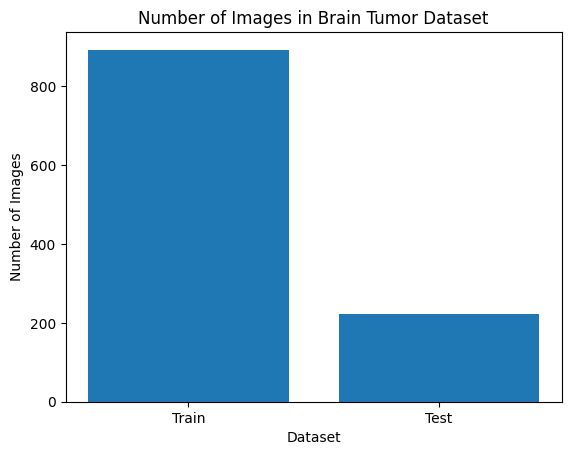

In [ ]:
train_data_dir = os.path.join('/kaggle/working', 'braintumors_coco', 'train')
test_data_dir = os.path.join('/kaggle/working', 'braintumors_coco', 'test')

# Get a list of all the image files in the training and test data directories.
train_image_files = glob(os.path.join(train_data_dir, '*.jpg'))
test_image_files = glob(os.path.join(test_data_dir, '*.jpg'))

# Count the number of image files in the training and test data directories.
num_train_images = len(train_image_files)
num_test_images = len(test_image_files)

# Plot the number of training and test images.
plt.bar(['Train', 'Test'], [num_train_images, num_test_images])
plt.title('Number of Images in Brain Tumor Dataset')
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.show()

In [ ]:
!tree -d {data_folder_coco}

braintumors_coco
|-- test
`-- train

2 directories


In [ ]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [ ]:
!pip install pycocotools
from pycocotools.coco import COCO

In [ ]:
from albumentations.pytorch import ToTensorV2

In [ ]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # input size image
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), #input size image
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

## Dataset

In [ ]:
class BrainTumorDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target]
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {}
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ
    def __len__(self):
        return len(self.ids)

In [ ]:
dataset_path = "/kaggle/working/braintumors_coco/"

In [ ]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


{1: {'id': 1, 'name': 'negative', 'supercategory': None},
 2: {'id': 2, 'name': 'positive', 'supercategory': None}}

In [ ]:
classes = [i[1]['name'] for i in categories.items()]
print(f"class: {classes}")

class: ['negative', 'positive']


In [ ]:
train_dataset = BrainTumorDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
# # Lets view a sample
# sample = train_dataset[2]
# img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
# plt.imshow(draw_bounding_boxes(
#     img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
# ).permute(1, 2, 0))

In [ ]:
len(train_dataset)

878

## Model

In [ ]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, 3)

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [ ]:
images,targets = next(iter(train_loader))
targets = [{k:v for k, v in t.items()} for t in targets]
targets

[{'boxes': tensor([[354.9294,  63.3804, 403.5210, 102.1128]]),
  'labels': tensor([2]),
  'image_id': tensor([136]),
  'area': tensor([1882.0686]),
  'iscrowd': tensor([0])},
 {'boxes': tensor([[345.0705, 227.4651, 400.7043, 287.3241]]),
  'labels': tensor([1]),
  'image_id': tensor([1446]),
  'area': tensor([3330.1843]),
  'iscrowd': tensor([0])},
 {'boxes': tensor([[174.6477, 177.4647, 235.2111, 247.1829]]),
  'labels': tensor([2]),
  'image_id': tensor([702]),
  'area': tensor([4222.3711]),
  'iscrowd': tensor([0])},
 {'boxes': tensor([[338.7327, 100.0002, 403.5213, 177.4650]]),
  'labels': tensor([1]),
  'image_id': tensor([1330]),
  'area': tensor([5018.8359]),
  'iscrowd': tensor([0])}]

In [ ]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [ ]:
device = torch.device("cuda") # use GPU to train

In [ ]:
model = model.to(device)

## Optimizer

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [ ]:
import sys

## Training

In [ ]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)

#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

#         if lr_scheduler is not None:
#             lr_scheduler.step() #

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [ ]:
num_epochs=50

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

100%|██████████| 220/220 [00:26<00:00,  8.17it/s]


Epoch 0, lr: 0.010000, loss: 0.723452, loss_classifier: 0.359293, loss_box: 0.355169, loss_rpn_box: 0.001665, loss_object: 0.007325


100%|██████████| 220/220 [00:26<00:00,  8.31it/s]


Epoch 1, lr: 0.010000, loss: 0.704438, loss_classifier: 0.369544, loss_box: 0.329931, loss_rpn_box: 0.001334, loss_object: 0.003629


100%|██████████| 220/220 [00:26<00:00,  8.29it/s]


Epoch 2, lr: 0.010000, loss: 0.714082, loss_classifier: 0.381828, loss_box: 0.328040, loss_rpn_box: 0.001164, loss_object: 0.003049


100%|██████████| 220/220 [00:26<00:00,  8.33it/s]


Epoch 3, lr: 0.010000, loss: 0.667402, loss_classifier: 0.357941, loss_box: 0.305433, loss_rpn_box: 0.001132, loss_object: 0.002897


100%|██████████| 220/220 [00:26<00:00,  8.39it/s]


Epoch 4, lr: 0.010000, loss: 0.659242, loss_classifier: 0.354747, loss_box: 0.300859, loss_rpn_box: 0.001017, loss_object: 0.002619


100%|██████████| 220/220 [00:26<00:00,  8.34it/s]


Epoch 5, lr: 0.010000, loss: 0.626217, loss_classifier: 0.340325, loss_box: 0.282361, loss_rpn_box: 0.000986, loss_object: 0.002544


100%|██████████| 220/220 [00:26<00:00,  8.35it/s]


Epoch 6, lr: 0.010000, loss: 0.641129, loss_classifier: 0.343319, loss_box: 0.293985, loss_rpn_box: 0.001007, loss_object: 0.002818


100%|██████████| 220/220 [00:26<00:00,  8.39it/s]


Epoch 7, lr: 0.010000, loss: 0.678259, loss_classifier: 0.361489, loss_box: 0.313394, loss_rpn_box: 0.000946, loss_object: 0.002430


100%|██████████| 220/220 [00:26<00:00,  8.34it/s]


Epoch 8, lr: 0.010000, loss: 0.616103, loss_classifier: 0.326699, loss_box: 0.285781, loss_rpn_box: 0.000998, loss_object: 0.002626


100%|██████████| 220/220 [00:26<00:00,  8.43it/s]


Epoch 9, lr: 0.010000, loss: 0.622558, loss_classifier: 0.323392, loss_box: 0.295778, loss_rpn_box: 0.000956, loss_object: 0.002432


100%|██████████| 220/220 [00:26<00:00,  8.42it/s]


Epoch 10, lr: 0.010000, loss: 0.631527, loss_classifier: 0.329374, loss_box: 0.298925, loss_rpn_box: 0.000911, loss_object: 0.002318


100%|██████████| 220/220 [00:26<00:00,  8.40it/s]


Epoch 11, lr: 0.010000, loss: 0.600261, loss_classifier: 0.317238, loss_box: 0.279610, loss_rpn_box: 0.000857, loss_object: 0.002557


100%|██████████| 220/220 [00:26<00:00,  8.45it/s]


Epoch 12, lr: 0.010000, loss: 0.619050, loss_classifier: 0.318535, loss_box: 0.297415, loss_rpn_box: 0.000918, loss_object: 0.002182


100%|██████████| 220/220 [00:26<00:00,  8.39it/s]


Epoch 13, lr: 0.010000, loss: 0.531819, loss_classifier: 0.272483, loss_box: 0.256099, loss_rpn_box: 0.000904, loss_object: 0.002334


100%|██████████| 220/220 [00:26<00:00,  8.43it/s]


Epoch 14, lr: 0.010000, loss: 0.549773, loss_classifier: 0.281767, loss_box: 0.264741, loss_rpn_box: 0.000900, loss_object: 0.002364


100%|██████████| 220/220 [00:25<00:00,  8.48it/s]


Epoch 15, lr: 0.010000, loss: 0.583774, loss_classifier: 0.290126, loss_box: 0.290720, loss_rpn_box: 0.000878, loss_object: 0.002049


100%|██████████| 220/220 [00:25<00:00,  8.47it/s]


Epoch 16, lr: 0.010000, loss: 0.565281, loss_classifier: 0.268327, loss_box: 0.293949, loss_rpn_box: 0.000880, loss_object: 0.002124


100%|██████████| 220/220 [00:25<00:00,  8.48it/s]


Epoch 17, lr: 0.010000, loss: 0.553574, loss_classifier: 0.265376, loss_box: 0.285309, loss_rpn_box: 0.000869, loss_object: 0.002020


100%|██████████| 220/220 [00:26<00:00,  8.45it/s]


Epoch 18, lr: 0.010000, loss: 0.546461, loss_classifier: 0.261992, loss_box: 0.281489, loss_rpn_box: 0.000867, loss_object: 0.002114


100%|██████████| 220/220 [00:25<00:00,  8.54it/s]


Epoch 19, lr: 0.010000, loss: 0.549698, loss_classifier: 0.255921, loss_box: 0.290850, loss_rpn_box: 0.000830, loss_object: 0.002096


100%|██████████| 220/220 [00:25<00:00,  8.57it/s]


Epoch 20, lr: 0.010000, loss: 0.616690, loss_classifier: 0.296558, loss_box: 0.317064, loss_rpn_box: 0.000874, loss_object: 0.002193


100%|██████████| 220/220 [00:25<00:00,  8.50it/s]


Epoch 21, lr: 0.010000, loss: 0.509403, loss_classifier: 0.231448, loss_box: 0.275210, loss_rpn_box: 0.000846, loss_object: 0.001899


100%|██████████| 220/220 [00:25<00:00,  8.53it/s]


Epoch 22, lr: 0.010000, loss: 0.544845, loss_classifier: 0.246409, loss_box: 0.295556, loss_rpn_box: 0.000887, loss_object: 0.001992


100%|██████████| 220/220 [00:25<00:00,  8.52it/s]


Epoch 23, lr: 0.010000, loss: 0.507611, loss_classifier: 0.227784, loss_box: 0.277089, loss_rpn_box: 0.000791, loss_object: 0.001947


100%|██████████| 220/220 [00:25<00:00,  8.48it/s]


Epoch 24, lr: 0.010000, loss: 0.527110, loss_classifier: 0.238755, loss_box: 0.285117, loss_rpn_box: 0.000855, loss_object: 0.002382


100%|██████████| 220/220 [00:25<00:00,  8.50it/s]


Epoch 25, lr: 0.010000, loss: 0.580645, loss_classifier: 0.272863, loss_box: 0.304775, loss_rpn_box: 0.000878, loss_object: 0.002129


100%|██████████| 220/220 [00:25<00:00,  8.53it/s]


Epoch 26, lr: 0.010000, loss: 0.558491, loss_classifier: 0.250672, loss_box: 0.305017, loss_rpn_box: 0.000855, loss_object: 0.001947


100%|██████████| 220/220 [00:25<00:00,  8.51it/s]


Epoch 27, lr: 0.010000, loss: 0.484107, loss_classifier: 0.206327, loss_box: 0.274953, loss_rpn_box: 0.000850, loss_object: 0.001978


100%|██████████| 220/220 [00:25<00:00,  8.55it/s]


Epoch 28, lr: 0.010000, loss: 0.554243, loss_classifier: 0.233475, loss_box: 0.317810, loss_rpn_box: 0.000857, loss_object: 0.002100


100%|██████████| 220/220 [00:25<00:00,  8.54it/s]


Epoch 29, lr: 0.010000, loss: 0.479696, loss_classifier: 0.196557, loss_box: 0.280409, loss_rpn_box: 0.000829, loss_object: 0.001901


100%|██████████| 220/220 [00:25<00:00,  8.56it/s]


Epoch 30, lr: 0.010000, loss: 0.517607, loss_classifier: 0.213710, loss_box: 0.301150, loss_rpn_box: 0.000824, loss_object: 0.001923


100%|██████████| 220/220 [00:25<00:00,  8.57it/s]


Epoch 31, lr: 0.010000, loss: 0.492561, loss_classifier: 0.199577, loss_box: 0.290448, loss_rpn_box: 0.000794, loss_object: 0.001742


100%|██████████| 220/220 [00:25<00:00,  8.50it/s]


Epoch 32, lr: 0.010000, loss: 0.455917, loss_classifier: 0.188260, loss_box: 0.264989, loss_rpn_box: 0.000807, loss_object: 0.001860


100%|██████████| 220/220 [00:25<00:00,  8.60it/s]


Epoch 33, lr: 0.010000, loss: 0.512478, loss_classifier: 0.207981, loss_box: 0.301996, loss_rpn_box: 0.000792, loss_object: 0.001709


100%|██████████| 220/220 [00:25<00:00,  8.56it/s]


Epoch 34, lr: 0.010000, loss: 0.490671, loss_classifier: 0.201806, loss_box: 0.286397, loss_rpn_box: 0.000813, loss_object: 0.001655


100%|██████████| 220/220 [00:25<00:00,  8.49it/s]


Epoch 35, lr: 0.010000, loss: 0.499557, loss_classifier: 0.218781, loss_box: 0.277669, loss_rpn_box: 0.000907, loss_object: 0.002200


100%|██████████| 220/220 [00:25<00:00,  8.58it/s]


Epoch 36, lr: 0.010000, loss: 0.494220, loss_classifier: 0.200248, loss_box: 0.291349, loss_rpn_box: 0.000804, loss_object: 0.001819


100%|██████████| 220/220 [00:25<00:00,  8.54it/s]


Epoch 37, lr: 0.010000, loss: 0.504986, loss_classifier: 0.215302, loss_box: 0.286962, loss_rpn_box: 0.000824, loss_object: 0.001898


100%|██████████| 220/220 [00:25<00:00,  8.55it/s]


Epoch 38, lr: 0.010000, loss: 0.503213, loss_classifier: 0.199815, loss_box: 0.300541, loss_rpn_box: 0.000830, loss_object: 0.002027


100%|██████████| 220/220 [00:25<00:00,  8.59it/s]


Epoch 39, lr: 0.010000, loss: 0.471197, loss_classifier: 0.179578, loss_box: 0.289030, loss_rpn_box: 0.000775, loss_object: 0.001814


100%|██████████| 220/220 [00:25<00:00,  8.58it/s]


Epoch 40, lr: 0.010000, loss: 0.471817, loss_classifier: 0.176858, loss_box: 0.292660, loss_rpn_box: 0.000766, loss_object: 0.001532


100%|██████████| 220/220 [00:25<00:00,  8.55it/s]


Epoch 41, lr: 0.010000, loss: 0.482830, loss_classifier: 0.192663, loss_box: 0.287705, loss_rpn_box: 0.000743, loss_object: 0.001718


100%|██████████| 220/220 [00:25<00:00,  8.57it/s]


Epoch 42, lr: 0.010000, loss: 0.435966, loss_classifier: 0.168952, loss_box: 0.264778, loss_rpn_box: 0.000767, loss_object: 0.001469


100%|██████████| 220/220 [00:25<00:00,  8.56it/s]


Epoch 43, lr: 0.010000, loss: 0.447980, loss_classifier: 0.181302, loss_box: 0.264239, loss_rpn_box: 0.000747, loss_object: 0.001691


100%|██████████| 220/220 [00:25<00:00,  8.58it/s]


Epoch 44, lr: 0.010000, loss: 0.492216, loss_classifier: 0.199441, loss_box: 0.290378, loss_rpn_box: 0.000767, loss_object: 0.001629


100%|██████████| 220/220 [00:25<00:00,  8.61it/s]


Epoch 45, lr: 0.010000, loss: 0.467152, loss_classifier: 0.180445, loss_box: 0.284013, loss_rpn_box: 0.000760, loss_object: 0.001934


100%|██████████| 220/220 [00:25<00:00,  8.63it/s]


Epoch 46, lr: 0.010000, loss: 0.477449, loss_classifier: 0.184982, loss_box: 0.290195, loss_rpn_box: 0.000731, loss_object: 0.001540


100%|██████████| 220/220 [00:25<00:00,  8.61it/s]


Epoch 47, lr: 0.010000, loss: 0.501268, loss_classifier: 0.189379, loss_box: 0.309604, loss_rpn_box: 0.000755, loss_object: 0.001530


100%|██████████| 220/220 [00:25<00:00,  8.64it/s]


Epoch 48, lr: 0.010000, loss: 0.475518, loss_classifier: 0.174254, loss_box: 0.298869, loss_rpn_box: 0.000725, loss_object: 0.001670


100%|██████████| 220/220 [00:25<00:00,  8.62it/s]

Epoch 49, lr: 0.010000, loss: 0.474739, loss_classifier: 0.172002, loss_box: 0.300319, loss_rpn_box: 0.000736, loss_object: 0.001683


## Test thử trên một vài bức ảnh

In [ ]:
model.eval()
torch.cuda.empty_cache()

In [ ]:
test_dataset = BrainTumorDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


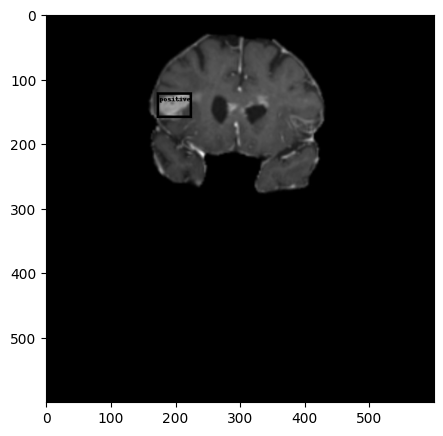

In [ ]:
img, _ = test_dataset[50]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]
fig = plt.figure(figsize=(5,6))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

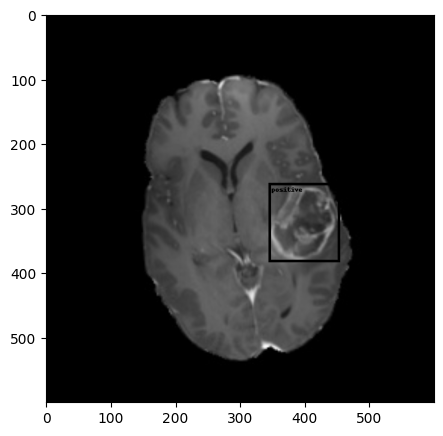

In [ ]:
img, _ = test_dataset[15]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]
fig = plt.figure(figsize=(5,6))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

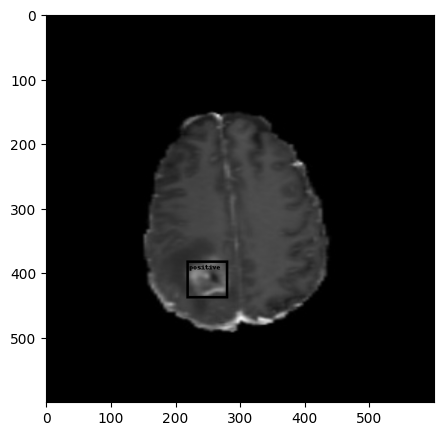

In [ ]:
img, _ = test_dataset[22]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]
fig = plt.figure(figsize=(5, 6))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

# save model

In [ ]:
path = '/kaggle/working/Braind_Tumor_with_FasterRCNN.pth'
torch.save(model.state_dict(), path)
